# Librerias

In [58]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval

# Funciones

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata




def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128):
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_data=(x_val,y_val))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    predichos=aux_model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')


# Cargar datos

## Generar imagenes con 3 canales

In [84]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [85]:
channel_1 = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u15_d15.npy')  
channel_2 = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u15_d15.npy')  
channel_3 = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/time_channel_30.npy')  

In [86]:
print(channel_1.shape)
print(channel_2.shape)
print(channel_3.shape)

(8054, 30, 30)
(8054, 30, 30)
(8054, 30, 30)


In [87]:
'''x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)'''

'x_all = []\nfor i in range(channel_1.shape[0]):\n    combined_image = np.dstack((channel_1[i],channel_2[i],channel_3[i]))\n    x_all.append(combined_image)\nx_all = np.asarray(x_all)'

In [88]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

## Generar conjunto de entrenamiento y validación

In [89]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [90]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [91]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [92]:
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 30, 30, 2) (4339,)
Objetos de validación: (1918, 30, 30, 2) (1918,)


## Generando class weight

In [93]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.79497985 1.34751553]


## PCA conjunto de prueba y validación

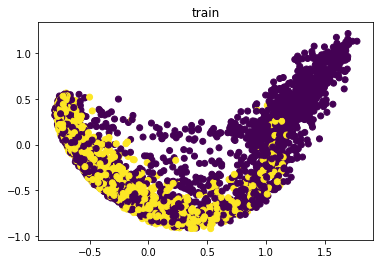

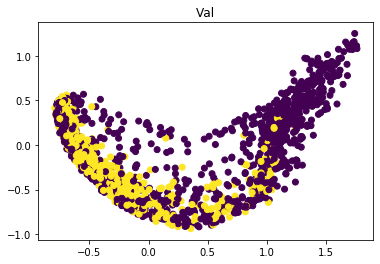

In [12]:
#nuevo test...

from sklearn.decomposition import PCA
dims_r = np.prod(x_train.shape[1:])
model = PCA(2)
plot_x = model.fit_transform(x_train.reshape([x_train.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_train, cmap='viridis') #morado es falso positivo
plt.title("train")
plt.show()

plot_x = model.transform(x_val.reshape([x_val.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_val, cmap='viridis') #morado es falso positivo
plt.title("Val")
plt.show()

## Pruebas CNN utilizando loss = binary_crossentropy

In [13]:
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2700)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               691456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 692,737
Trainable params: 692,225
Non-trainable params: 512
___________________________________________________________

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 2s 353us/step - loss: 0.7901 - acc: 0.5997 - val_loss: 4.0586 - val_acc: 0.3613
Epoch 2/25
4339/4339 [==============================] - 0s 83us/step - loss: 0.6036 - acc: 0.6601 - val_loss: 0.6350 - val_acc: 0.6319
Epoch 3/25
4339/4339 [==============================] - 0s 79us/step - loss: 0.5499 - acc: 0.6912 - val_loss: 0.7943 - val_acc: 0.5996
Epoch 4/25
4339/4339 [==============================] - 0s 77us/step - loss: 0.5399 - acc: 0.6997 - val_loss: 0.6506 - val_acc: 0.6350
Epoch 5/25
4339/4339 [==============================] - 0s 77us/step - loss: 0.5262 - acc: 0.7138 - val_loss: 0.8062 - val_acc: 0.6027
Epoch 6/25
4339/4339 [==============================] - 0s 77us/step - loss: 0.5070 - acc: 0.7223 - val_loss: 1.2468 - val_acc: 0.5422
Epoch 7/25
4339/4339 [==============================] - 0s 90us/step - loss: 0.4995 - acc: 0.7304 - val_loss: 1.4212 - val_acc: 0.5344
Epoch 

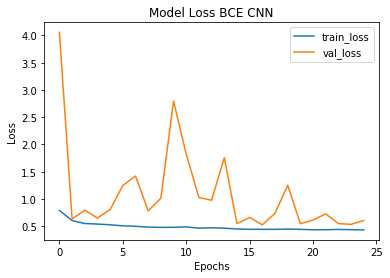

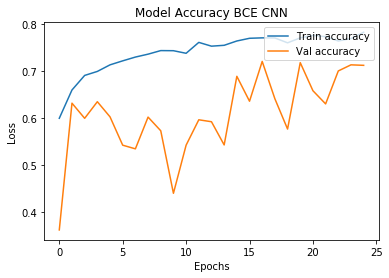

In [14]:
hist=model.fit(x_train, y_train, batch_size=128, epochs=25, verbose=1, validation_data=(x_val,y_val))

plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.702091,0.969527,0.814416,0.657007,0.589445,0.712722
Confirmed,0.806122,0.235469,0.364475,0.657007,0.589445,0.712722


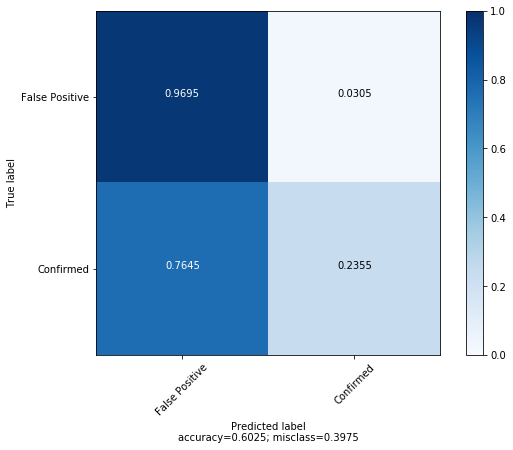

{'Precision raw': array([0.70209059, 0.80612245]), 'Recall raw': array([0.96952686, 0.23546945]), 'F1 raw': array([0.81441563, 0.3644752 ]), 'F1 weighted': 0.6570068554488301, 'F1 macro': 0.5894454150015365, 'F1 micro': 0.7127215849843588, 'Confusion Matrix': array([[1209,   38],
       [ 513,  158]])}


In [15]:
predichos=model.predict_classes(x_val)
print (calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC'))

### Modelo 1

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
#model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 11, 64)      

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 9s 2ms/step - loss: 0.6247 - acc: 0.6285 - val_loss: 0.5878 - val_acc: 0.6502
Epoch 2/25
4339/4339 [==============================] - 6s 1ms/step - loss: 0.5760 - acc: 0.6289 - val_loss: 0.5593 - val_acc: 0.6502
Epoch 3/25
4339/4339 [==============================] - 7s 1ms/step - loss: 0.5738 - acc: 0.6289 - val_loss: 0.5604 - val_acc: 0.6502
Epoch 4/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5702 - acc: 0.6289 - val_loss: 0.5552 - val_acc: 0.6502
Epoch 5/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5696 - acc: 0.6289 - val_loss: 0.5499 - val_acc: 0.6502
Epoch 6/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5581 - acc: 0.6289 - val_loss: 0.5465 - val_acc: 0.6502
Epoch 7/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5478 - acc: 0.6287 - val_loss: 0.5377 - val_acc: 0.6502
Epoch 8/25
433

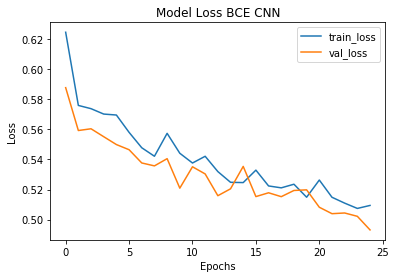

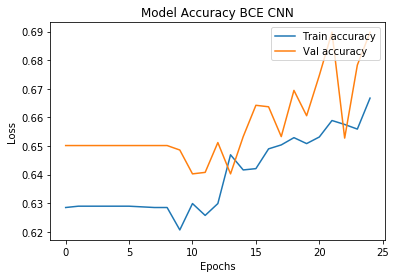

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.693587,0.936648,0.796998,0.638009,0.56977,0.689781
Confirmed,0.662393,0.230999,0.342541,0.638009,0.56977,0.689781


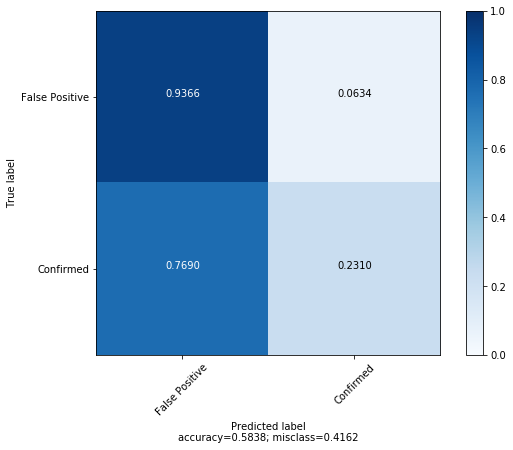

In [17]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5042 - acc: 0.6702 - val_loss: 0.5142 - val_acc: 0.6783
Epoch 2/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5049 - acc: 0.6771 - val_loss: 0.4965 - val_acc: 0.6950
Epoch 3/40
4339/4339 [==============================] - 7s 1ms/step - loss: 0.5006 - acc: 0.6771 - val_loss: 0.4971 - val_acc: 0.6893
Epoch 4/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5054 - acc: 0.6723 - val_loss: 0.4923 - val_acc: 0.6783
Epoch 5/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5012 - acc: 0.6833 - val_loss: 0.4904 - val_acc: 0.6778
Epoch 6/40
4339/4339 [==============================] - 6s 1ms/step - loss: 0.5031 - acc: 0.6831 - val_loss: 0.4990 - val_acc: 0.6788
Epoch 7/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.4923 - acc: 0.6870 - val_loss: 0.4829 - val_acc: 0.7247
Epoch 8/40
433

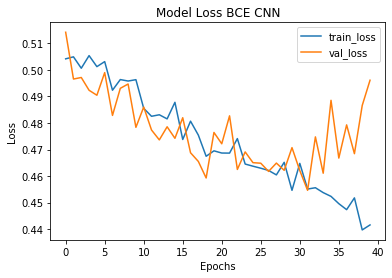

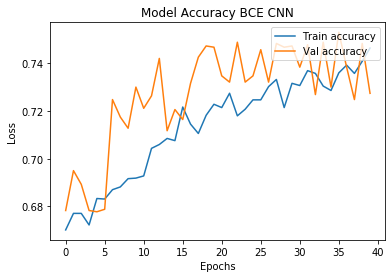

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.73385,0.910986,0.812880,0.702581,0.655239,0.72732
Confirmed,0.70000,0.385991,0.497598,0.702581,0.655239,0.72732


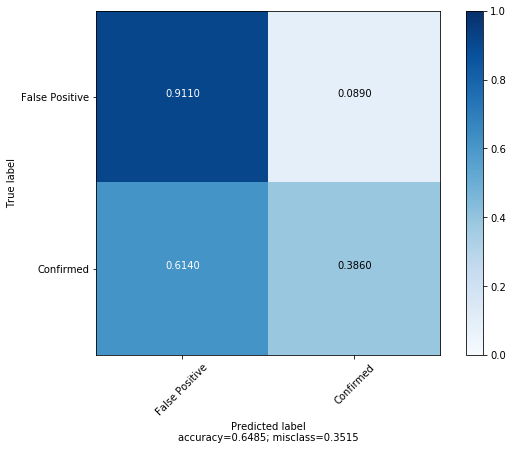

In [18]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

### Modelo 2

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(64, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)        

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 6s 1ms/step - loss: 0.6200 - acc: 0.6197 - val_loss: 0.5740 - val_acc: 0.6502
Epoch 2/25
4339/4339 [==============================] - 4s 862us/step - loss: 0.5738 - acc: 0.6289 - val_loss: 0.5630 - val_acc: 0.6502
Epoch 3/25
4339/4339 [==============================] - 4s 849us/step - loss: 0.5654 - acc: 0.6278 - val_loss: 0.5526 - val_acc: 0.6502
Epoch 4/25
4339/4339 [==============================] - 4s 856us/step - loss: 0.5587 - acc: 0.6377 - val_loss: 0.5439 - val_acc: 0.6288
Epoch 5/25
4339/4339 [==============================] - 4s 868us/step - loss: 0.5447 - acc: 0.6243 - val_loss: 0.5345 - val_acc: 0.6496
Epoch 6/25
4339/4339 [==============================] - 4s 875us/step - loss: 0.5479 - acc: 0.6347 - val_loss: 0.5249 - val_acc: 0.6533
Epoch 7/25
4339/4339 [==============================] - 4s 855us/step - loss: 0.5353 - acc: 0.6382 - val_loss: 0.5296 - val_acc: 0.6356
Ep

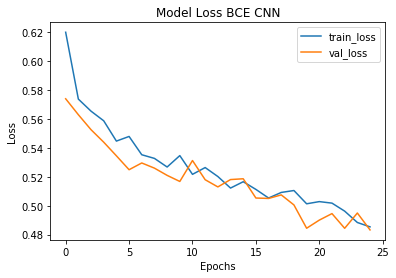

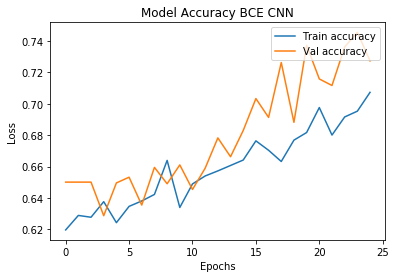

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.748285,0.874900,0.806654,0.712519,0.672116,0.72732
Confirmed,0.660870,0.453055,0.537577,0.712519,0.672116,0.72732


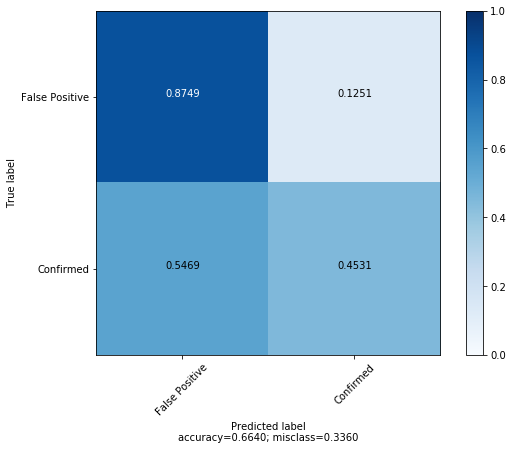

In [20]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 4s 884us/step - loss: 0.4826 - acc: 0.7089 - val_loss: 0.4675 - val_acc: 0.7487
Epoch 2/40
4339/4339 [==============================] - 4s 870us/step - loss: 0.4786 - acc: 0.7140 - val_loss: 0.4898 - val_acc: 0.7388
Epoch 3/40
4339/4339 [==============================] - 4s 856us/step - loss: 0.4760 - acc: 0.7117 - val_loss: 0.4810 - val_acc: 0.7331
Epoch 4/40
4339/4339 [==============================] - 4s 839us/step - loss: 0.4750 - acc: 0.7112 - val_loss: 0.4871 - val_acc: 0.7393
Epoch 5/40
4339/4339 [==============================] - 4s 867us/step - loss: 0.4722 - acc: 0.7211 - val_loss: 0.4710 - val_acc: 0.7377
Epoch 6/40
4339/4339 [==============================] - 4s 868us/step - loss: 0.4740 - acc: 0.7147 - val_loss: 0.4783 - val_acc: 0.7383
Epoch 7/40
4339/4339 [==============================] - 4s 858us/step - loss: 0.4663 - acc: 0.7211 - val_loss: 0.4713 - val_acc: 0.7372


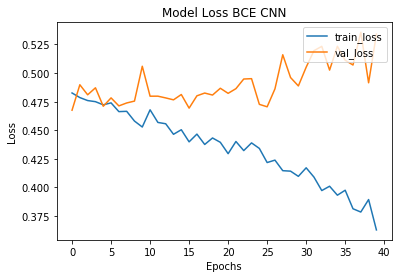

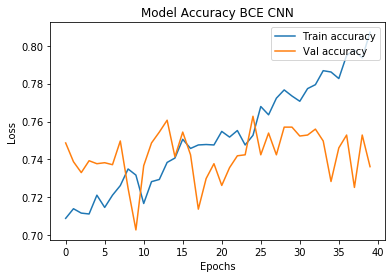

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.809008,0.777867,0.793132,0.73815,0.714551,0.736184
Confirmed,0.614743,0.658718,0.635971,0.73815,0.714551,0.736184


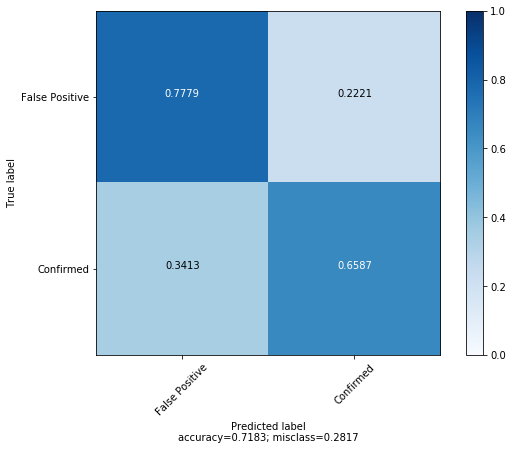

In [21]:
train_model(model, x_train, y_train, x_val, y_val, e=40) 

In [22]:
#train_model(model, x_train, y_train, x_val, y_val, e=200) 

### Modelo 3

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 128)       36992     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)        

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 4s 967us/step - loss: 0.6330 - acc: 0.6280 - val_loss: 0.5627 - val_acc: 0.6502
Epoch 2/25
4339/4339 [==============================] - 2s 550us/step - loss: 0.5679 - acc: 0.6310 - val_loss: 0.5555 - val_acc: 0.6512
Epoch 3/25
4339/4339 [==============================] - 2s 550us/step - loss: 0.5657 - acc: 0.6223 - val_loss: 0.5520 - val_acc: 0.6543
Epoch 4/25
4339/4339 [==============================] - 2s 559us/step - loss: 0.5563 - acc: 0.6216 - val_loss: 0.5420 - val_acc: 0.6283
Epoch 5/25
4339/4339 [==============================] - 2s 558us/step - loss: 0.5529 - acc: 0.6257 - val_loss: 0.5416 - val_acc: 0.6303
Epoch 6/25
4339/4339 [==============================] - 2s 557us/step - loss: 0.5388 - acc: 0.6324 - val_loss: 0.5277 - val_acc: 0.6429
Epoch 7/25
4339/4339 [==============================] - 2s 556us/step - loss: 0.5359 - acc: 0.6382 - val_loss: 0.5393 - val_acc: 0.6272


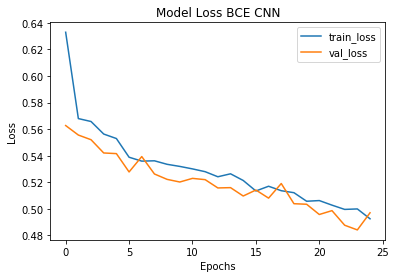

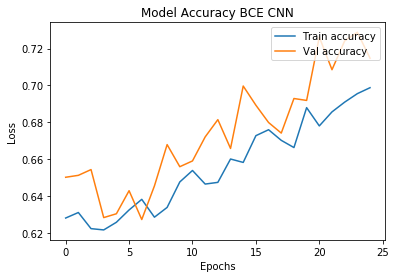

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.755102,0.830794,0.791142,0.706967,0.670838,0.714807
Confirmed,0.613553,0.499255,0.550534,0.706967,0.670838,0.714807


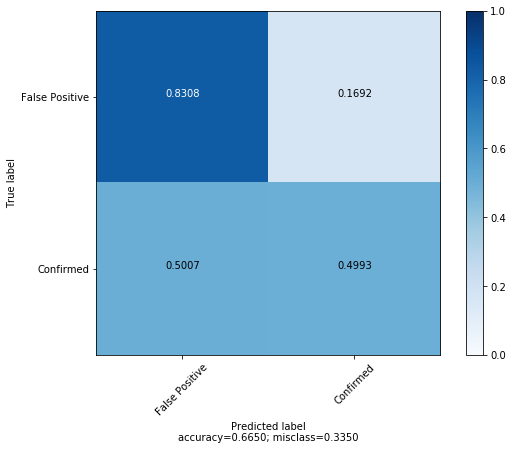

In [24]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 563us/step - loss: 0.4865 - acc: 0.6990 - val_loss: 0.4840 - val_acc: 0.6877
Epoch 2/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4922 - acc: 0.6932 - val_loss: 0.4978 - val_acc: 0.7158
Epoch 3/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4871 - acc: 0.7036 - val_loss: 0.4801 - val_acc: 0.7310
Epoch 4/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4818 - acc: 0.7117 - val_loss: 0.4892 - val_acc: 0.7341
Epoch 5/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4798 - acc: 0.7131 - val_loss: 0.4771 - val_acc: 0.7153
Epoch 6/40
4339/4339 [==============================] - 2s 549us/step - loss: 0.4789 - acc: 0.7101 - val_loss: 0.4773 - val_acc: 0.7252
Epoch 7/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4799 - acc: 0.7087 - val_loss: 0.4678 - val_acc: 0.7393


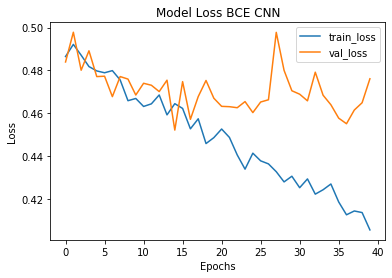

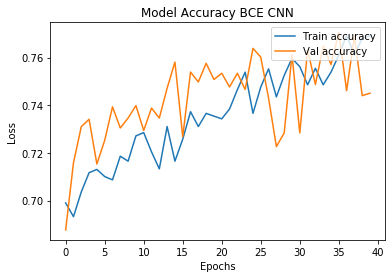

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.814262,0.78749,0.800652,0.746695,0.723537,0.745047
Confirmed,0.627809,0.66617,0.646421,0.746695,0.723537,0.745047


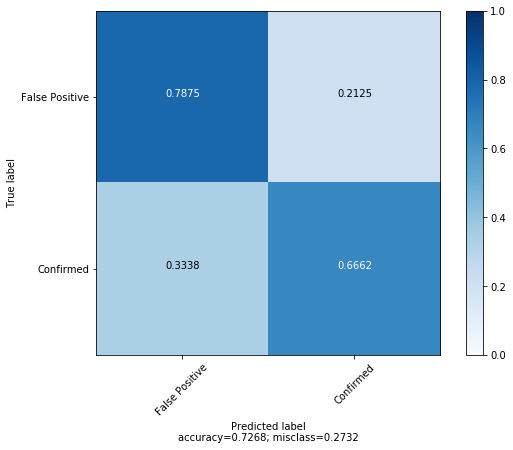

In [25]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

### Modelo 4

In [26]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 128)     

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.7963 - acc: 0.5935 - val_loss: 1.0067 - val_acc: 0.6512
Epoch 2/25
4339/4339 [==============================] - 4s 833us/step - loss: 0.6455 - acc: 0.6091 - val_loss: 1.0062 - val_acc: 0.5839
Epoch 3/25
4339/4339 [==============================] - 4s 823us/step - loss: 0.6016 - acc: 0.6177 - val_loss: 0.7884 - val_acc: 0.5954
Epoch 4/25
4339/4339 [==============================] - 4s 823us/step - loss: 0.5836 - acc: 0.6289 - val_loss: 0.8926 - val_acc: 0.5798
Epoch 5/25
4339/4339 [==============================] - 4s 826us/step - loss: 0.5751 - acc: 0.6269 - val_loss: 0.7179 - val_acc: 0.5839
Epoch 6/25
4339/4339 [==============================] - 4s 860us/step - loss: 0.5643 - acc: 0.6356 - val_loss: 0.5838 - val_acc: 0.6262
Epoch 7/25
4339/4339 [==============================] - 4s 840us/step - loss: 0.5578 - acc: 0.6366 - val_loss: 0.5416 - val_acc: 0.6554
Ep

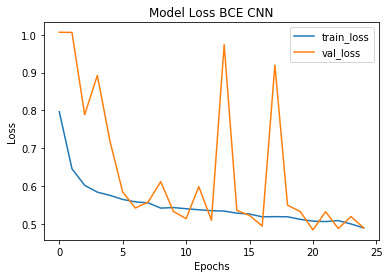

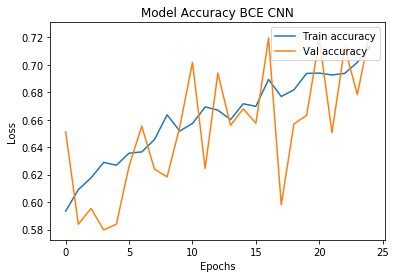

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.731141,0.909383,0.810579,0.698218,0.649991,0.72367
Confirmed,0.692098,0.378539,0.489403,0.698218,0.649991,0.72367


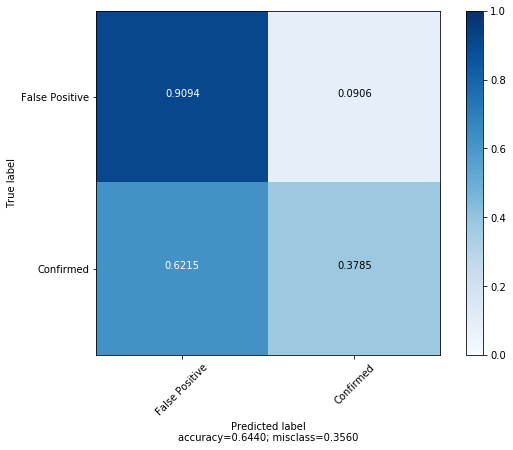

In [27]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 4s 855us/step - loss: 0.4989 - acc: 0.7064 - val_loss: 0.4825 - val_acc: 0.7153
Epoch 2/40
4339/4339 [==============================] - 4s 843us/step - loss: 0.4903 - acc: 0.7121 - val_loss: 0.5201 - val_acc: 0.6851
Epoch 3/40
4339/4339 [==============================] - 4s 848us/step - loss: 0.4936 - acc: 0.7089 - val_loss: 0.5187 - val_acc: 0.6809
Epoch 4/40
4339/4339 [==============================] - 4s 847us/step - loss: 0.4905 - acc: 0.7085 - val_loss: 0.5688 - val_acc: 0.6872
Epoch 5/40
4339/4339 [==============================] - 4s 848us/step - loss: 0.4903 - acc: 0.7085 - val_loss: 0.5765 - val_acc: 0.6710
Epoch 6/40
4339/4339 [==============================] - 4s 834us/step - loss: 0.4780 - acc: 0.7248 - val_loss: 0.4798 - val_acc: 0.7013
Epoch 7/40
4339/4339 [==============================] - 4s 835us/step - loss: 0.4785 - acc: 0.7177 - val_loss: 0.4598 - val_acc: 0.7503


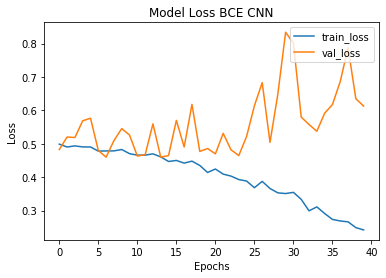

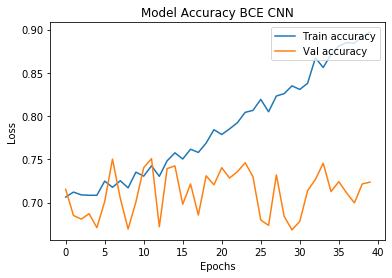

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.827996,0.725742,0.773504,0.7288,0.709613,0.72367
Confirmed,0.585455,0.719821,0.645722,0.7288,0.709613,0.72367


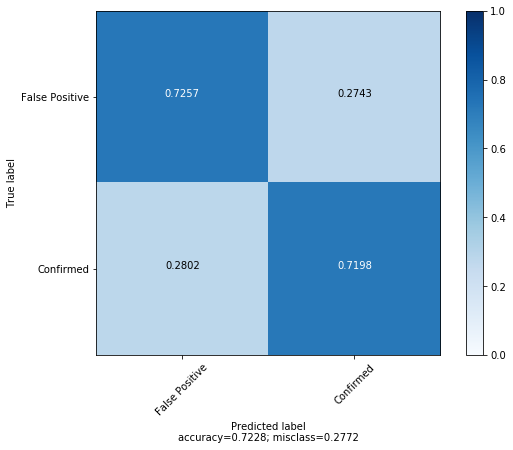

In [28]:
train_model(model, x_train, y_train, x_val, y_val, e=40) 

### Modelo 5

In [69]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1152)            

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 3s 656us/step - loss: 0.6271 - acc: 0.6190 - val_loss: 0.5618 - val_acc: 0.6293
Epoch 2/25
4339/4339 [==============================] - 1s 200us/step - loss: 0.5756 - acc: 0.6188 - val_loss: 0.5545 - val_acc: 0.6481
Epoch 3/25
4339/4339 [==============================] - 1s 195us/step - loss: 0.5604 - acc: 0.6218 - val_loss: 0.5479 - val_acc: 0.6309
Epoch 4/25
4339/4339 [==============================] - 1s 198us/step - loss: 0.5558 - acc: 0.6317 - val_loss: 0.5394 - val_acc: 0.6481
Epoch 5/25
4339/4339 [==============================] - 1s 198us/step - loss: 0.5498 - acc: 0.6204 - val_loss: 0.5367 - val_acc: 0.6496
Epoch 6/25
4339/4339 [==============================] - 1s 198us/step - loss: 0.5439 - acc: 0.6368 - val_loss: 0.5311 - val_acc: 0.6481
Epoch 7/25
4339/4339 [==============================] - 1s 198us/step - loss: 0.5393 - acc: 0.6354 - val_loss: 0.5269 - val_acc: 0.6580


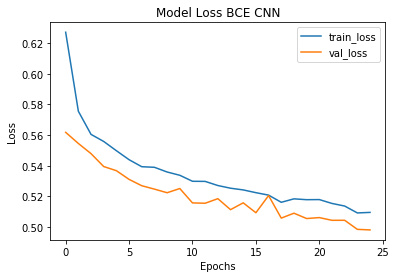

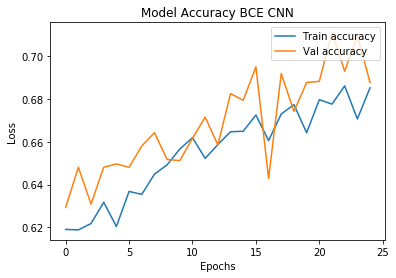

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.802239,0.689655,0.741699,0.693925,0.67342,0.687696
Confirmed,0.542553,0.684054,0.605142,0.693925,0.67342,0.687696


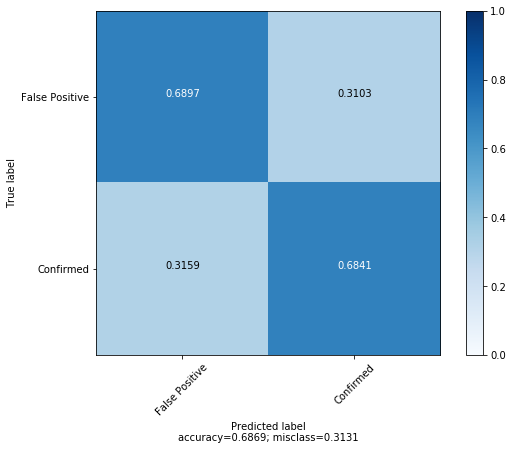

In [70]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 1s 217us/step - loss: 0.5117 - acc: 0.6737 - val_loss: 0.4999 - val_acc: 0.7117
Epoch 2/40
4339/4339 [==============================] - 1s 199us/step - loss: 0.5106 - acc: 0.6778 - val_loss: 0.4980 - val_acc: 0.7075
Epoch 3/40
4339/4339 [==============================] - 1s 199us/step - loss: 0.5096 - acc: 0.6817 - val_loss: 0.4919 - val_acc: 0.7132
Epoch 4/40
4339/4339 [==============================] - 1s 199us/step - loss: 0.5035 - acc: 0.6898 - val_loss: 0.4928 - val_acc: 0.7231
Epoch 5/40
4339/4339 [==============================] - 1s 199us/step - loss: 0.5045 - acc: 0.6905 - val_loss: 0.4879 - val_acc: 0.7174
Epoch 6/40
4339/4339 [==============================] - 1s 198us/step - loss: 0.5014 - acc: 0.6953 - val_loss: 0.4912 - val_acc: 0.7164
Epoch 7/40
4339/4339 [==============================] - 1s 198us/step - loss: 0.4991 - acc: 0.6949 - val_loss: 0.4862 - val_acc: 0.7195


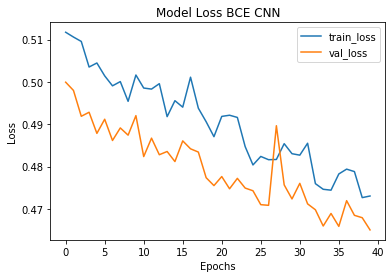

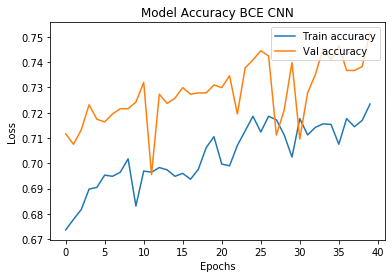

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.767894,0.886127,0.822785,0.739978,0.704436,0.751825
Confirmed,0.703549,0.502235,0.586087,0.739978,0.704436,0.751825


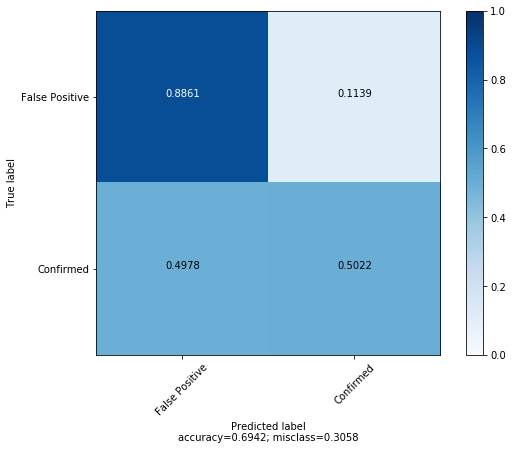

In [71]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 216us/step - loss: 0.4730 - acc: 0.7202 - val_loss: 0.4664 - val_acc: 0.7440
Epoch 2/200
4339/4339 [==============================] - 1s 199us/step - loss: 0.4741 - acc: 0.7186 - val_loss: 0.4725 - val_acc: 0.7482
Epoch 3/200
4339/4339 [==============================] - 1s 199us/step - loss: 0.4707 - acc: 0.7232 - val_loss: 0.4614 - val_acc: 0.7529
Epoch 4/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.4673 - acc: 0.7276 - val_loss: 0.4614 - val_acc: 0.7487
Epoch 5/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.4674 - acc: 0.7274 - val_loss: 0.4658 - val_acc: 0.7331
Epoch 6/200
4339/4339 [==============================] - 1s 198us/step - loss: 0.4718 - acc: 0.7251 - val_loss: 0.4726 - val_acc: 0.7278
Epoch 7/200
4339/4339 [==============================] - 1s 198us/step - loss: 0.4702 - acc: 0.7214 - val_loss: 0.4647 - val_acc: 

4339/4339 [==============================] - 1s 196us/step - loss: 0.4330 - acc: 0.7647 - val_loss: 0.4521 - val_acc: 0.7643
Epoch 61/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.4321 - acc: 0.7594 - val_loss: 0.4493 - val_acc: 0.7690
Epoch 62/200
4339/4339 [==============================] - 1s 195us/step - loss: 0.4339 - acc: 0.7550 - val_loss: 0.4548 - val_acc: 0.7576
Epoch 63/200
4339/4339 [==============================] - 1s 195us/step - loss: 0.4270 - acc: 0.7663 - val_loss: 0.4547 - val_acc: 0.7581
Epoch 64/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.4308 - acc: 0.7539 - val_loss: 0.4556 - val_acc: 0.7607
Epoch 65/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.4335 - acc: 0.7534 - val_loss: 0.4561 - val_acc: 0.7544
Epoch 66/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.4319 - acc: 0.7628 - val_loss: 0.4544 - val_acc: 0.7570
Epoch 67/200
4339/4339 [=======================

4339/4339 [==============================] - 1s 196us/step - loss: 0.3914 - acc: 0.7928 - val_loss: 0.4668 - val_acc: 0.7492
Epoch 120/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.3851 - acc: 0.8004 - val_loss: 0.4525 - val_acc: 0.7758
Epoch 121/200
4339/4339 [==============================] - 1s 195us/step - loss: 0.3761 - acc: 0.8071 - val_loss: 0.4565 - val_acc: 0.7690
Epoch 122/200
4339/4339 [==============================] - 1s 198us/step - loss: 0.3900 - acc: 0.7921 - val_loss: 0.4538 - val_acc: 0.7602
Epoch 123/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.3913 - acc: 0.7930 - val_loss: 0.4528 - val_acc: 0.7628
Epoch 124/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3828 - acc: 0.7995 - val_loss: 0.4668 - val_acc: 0.7659
Epoch 125/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.3912 - acc: 0.7953 - val_loss: 0.4581 - val_acc: 0.7696
Epoch 126/200
4339/4339 [================

4339/4339 [==============================] - 1s 197us/step - loss: 0.3453 - acc: 0.8276 - val_loss: 0.4570 - val_acc: 0.7742
Epoch 179/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3456 - acc: 0.8242 - val_loss: 0.4630 - val_acc: 0.7602
Epoch 180/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3424 - acc: 0.8301 - val_loss: 0.4651 - val_acc: 0.7696
Epoch 181/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.3294 - acc: 0.8394 - val_loss: 0.4666 - val_acc: 0.7716
Epoch 182/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3449 - acc: 0.8348 - val_loss: 0.4555 - val_acc: 0.7753
Epoch 183/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3478 - acc: 0.8297 - val_loss: 0.4690 - val_acc: 0.7586
Epoch 184/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3345 - acc: 0.8345 - val_loss: 0.4687 - val_acc: 0.7607
Epoch 185/200
4339/4339 [================

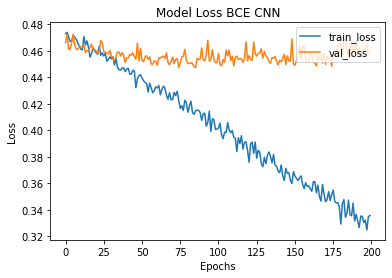

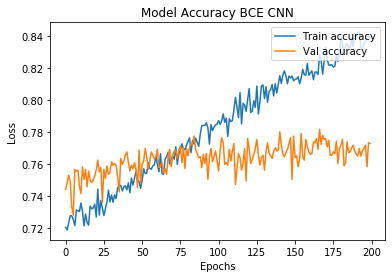

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.829407,0.818765,0.824052,0.773285,0.751496,0.77268
Confirmed,0.671033,0.687034,0.678940,0.773285,0.751496,0.77268


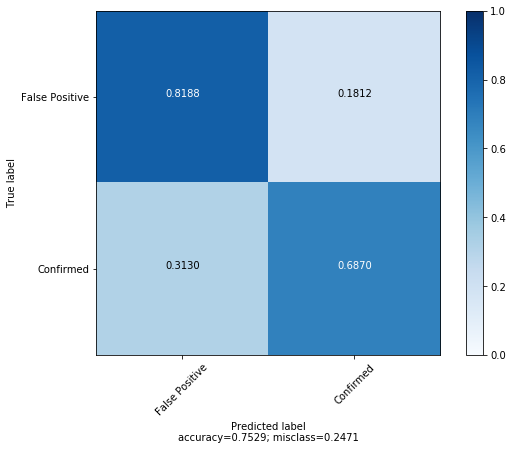

In [72]:
train_model(model, x_train, y_train, x_val, y_val, e=200)

### Modelo 5 con 2 canales

In [94]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

#model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               147584    
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)             

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 3s 666us/step - loss: 0.6128 - acc: 0.6257 - val_loss: 0.5603 - val_acc: 0.6309
Epoch 2/25
4339/4339 [==============================] - 1s 169us/step - loss: 0.5637 - acc: 0.6241 - val_loss: 0.5501 - val_acc: 0.6142
Epoch 3/25
4339/4339 [==============================] - 1s 150us/step - loss: 0.5564 - acc: 0.6278 - val_loss: 0.5476 - val_acc: 0.6330
Epoch 4/25
4339/4339 [==============================] - 1s 155us/step - loss: 0.5502 - acc: 0.6160 - val_loss: 0.5405 - val_acc: 0.6413
Epoch 5/25
4339/4339 [==============================] - 0s 112us/step - loss: 0.5444 - acc: 0.6276 - val_loss: 0.5375 - val_acc: 0.6423
Epoch 6/25
4339/4339 [==============================] - 1s 151us/step - loss: 0.5423 - acc: 0.6458 - val_loss: 0.5322 - val_acc: 0.6606
Epoch 7/25
4339/4339 [==============================] - 1s 142us/step - loss: 0.5373 - acc: 0.6460 - val_loss: 0.5267 - val_acc: 0.6773


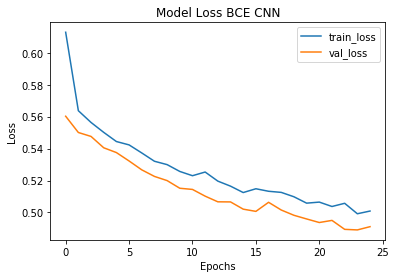

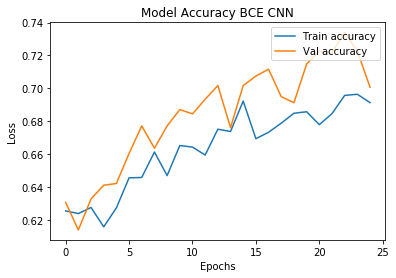

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.816557,0.696071,0.751515,0.706853,0.687684,0.70073
Confirmed,0.556725,0.709389,0.623853,0.706853,0.687684,0.70073


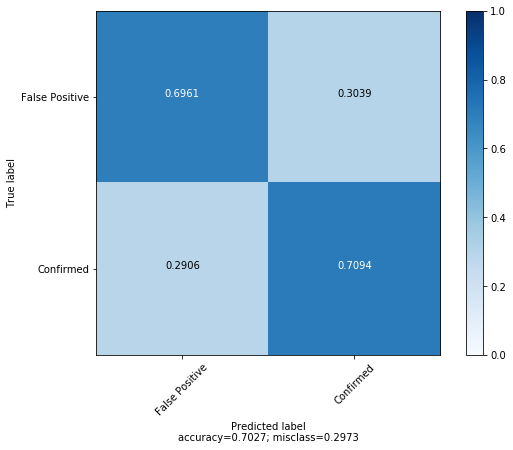

In [95]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 1s 198us/step - loss: 0.4979 - acc: 0.6942 - val_loss: 0.4877 - val_acc: 0.7164
Epoch 2/40
4339/4339 [==============================] - 1s 205us/step - loss: 0.4947 - acc: 0.7020 - val_loss: 0.4855 - val_acc: 0.7195
Epoch 3/40
4339/4339 [==============================] - 1s 182us/step - loss: 0.4954 - acc: 0.7020 - val_loss: 0.4862 - val_acc: 0.7284
Epoch 4/40
4339/4339 [==============================] - 1s 169us/step - loss: 0.4934 - acc: 0.7034 - val_loss: 0.4829 - val_acc: 0.7195
Epoch 5/40
4339/4339 [==============================] - 1s 162us/step - loss: 0.4947 - acc: 0.6919 - val_loss: 0.4833 - val_acc: 0.7367
Epoch 6/40
4339/4339 [==============================] - 1s 169us/step - loss: 0.4865 - acc: 0.7091 - val_loss: 0.4827 - val_acc: 0.7190
Epoch 7/40
4339/4339 [==============================] - 1s 197us/step - loss: 0.4890 - acc: 0.6992 - val_loss: 0.4827 - val_acc: 0.7278


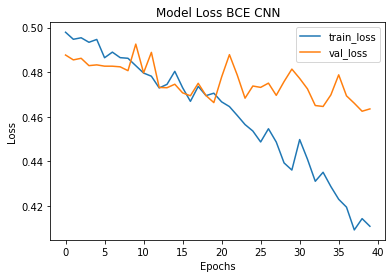

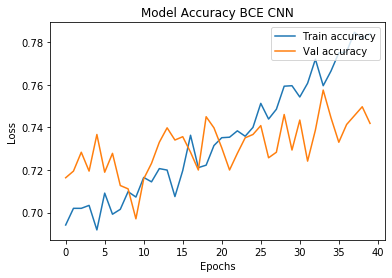

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.781437,0.837209,0.808362,0.737199,0.706655,0.741919
Confirmed,0.651203,0.564829,0.604948,0.737199,0.706655,0.741919


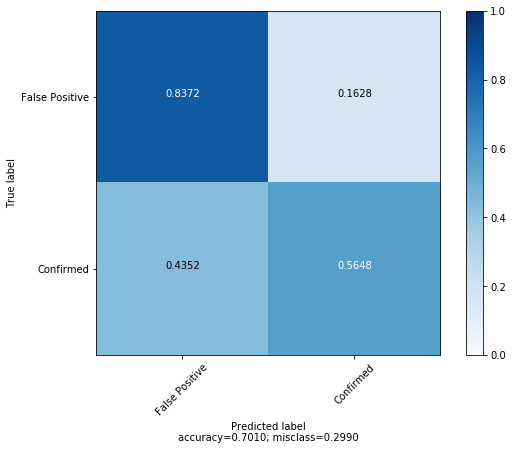

In [96]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 187us/step - loss: 0.4109 - acc: 0.7815 - val_loss: 0.4798 - val_acc: 0.7419
Epoch 2/200
4339/4339 [==============================] - 1s 170us/step - loss: 0.4068 - acc: 0.7919 - val_loss: 0.4716 - val_acc: 0.7492
Epoch 3/200
4339/4339 [==============================] - 1s 137us/step - loss: 0.3965 - acc: 0.7933 - val_loss: 0.4757 - val_acc: 0.7456
Epoch 4/200
4339/4339 [==============================] - 1s 162us/step - loss: 0.3992 - acc: 0.7933 - val_loss: 0.4785 - val_acc: 0.7482
Epoch 5/200
4339/4339 [==============================] - 1s 151us/step - loss: 0.4026 - acc: 0.7877 - val_loss: 0.4699 - val_acc: 0.7393
Epoch 6/200
4339/4339 [==============================] - 1s 129us/step - loss: 0.3962 - acc: 0.8029 - val_loss: 0.4712 - val_acc: 0.7440
Epoch 7/200
4339/4339 [==============================] - 1s 139us/step - loss: 0.3919 - acc: 0.8073 - val_loss: 0.4806 - val_acc: 

4339/4339 [==============================] - 1s 190us/step - loss: 0.1381 - acc: 0.9587 - val_loss: 0.6965 - val_acc: 0.7393
Epoch 61/200
4339/4339 [==============================] - 1s 133us/step - loss: 0.1449 - acc: 0.9479 - val_loss: 0.7280 - val_acc: 0.7487
Epoch 62/200
4339/4339 [==============================] - 1s 138us/step - loss: 0.1413 - acc: 0.9528 - val_loss: 0.7033 - val_acc: 0.7377
Epoch 63/200
4339/4339 [==============================] - 1s 146us/step - loss: 0.1538 - acc: 0.9440 - val_loss: 0.7090 - val_acc: 0.7419
Epoch 64/200
4339/4339 [==============================] - 1s 148us/step - loss: 0.1262 - acc: 0.9606 - val_loss: 0.7553 - val_acc: 0.7492
Epoch 65/200
4339/4339 [==============================] - 1s 184us/step - loss: 0.1206 - acc: 0.9643 - val_loss: 0.7470 - val_acc: 0.7424
Epoch 66/200
4339/4339 [==============================] - 1s 181us/step - loss: 0.1186 - acc: 0.9664 - val_loss: 0.7374 - val_acc: 0.7388
Epoch 67/200
4339/4339 [=======================

4339/4339 [==============================] - 1s 133us/step - loss: 0.0270 - acc: 0.9947 - val_loss: 1.2173 - val_acc: 0.7435
Epoch 120/200
4339/4339 [==============================] - 1s 162us/step - loss: 0.0286 - acc: 0.9942 - val_loss: 1.2112 - val_acc: 0.7492
Epoch 121/200
4339/4339 [==============================] - 1s 144us/step - loss: 0.0282 - acc: 0.9933 - val_loss: 1.1528 - val_acc: 0.7404
Epoch 122/200
4339/4339 [==============================] - 1s 126us/step - loss: 0.0298 - acc: 0.9945 - val_loss: 1.2118 - val_acc: 0.7482
Epoch 123/200
4339/4339 [==============================] - 1s 204us/step - loss: 0.0286 - acc: 0.9954 - val_loss: 1.2658 - val_acc: 0.7550
Epoch 124/200
4339/4339 [==============================] - 1s 136us/step - loss: 0.0260 - acc: 0.9949 - val_loss: 1.1627 - val_acc: 0.7450
Epoch 125/200
4339/4339 [==============================] - 1s 139us/step - loss: 0.0290 - acc: 0.9954 - val_loss: 1.2382 - val_acc: 0.7414
Epoch 126/200
4339/4339 [================

4339/4339 [==============================] - 0s 112us/step - loss: 0.0073 - acc: 0.9991 - val_loss: 1.5444 - val_acc: 0.7450
Epoch 179/200
4339/4339 [==============================] - 1s 135us/step - loss: 0.0092 - acc: 0.9986 - val_loss: 1.5098 - val_acc: 0.7445
Epoch 180/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 1.5950 - val_acc: 0.7487
Epoch 181/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 1.6926 - val_acc: 0.7508
Epoch 182/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0053 - acc: 0.9998 - val_loss: 1.6381 - val_acc: 0.7456
Epoch 183/200
4339/4339 [==============================] - 1s 120us/step - loss: 0.0058 - acc: 0.9998 - val_loss: 1.6544 - val_acc: 0.7471
Epoch 184/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0106 - acc: 0.9972 - val_loss: 1.6033 - val_acc: 0.7477
Epoch 185/200
4339/4339 [================

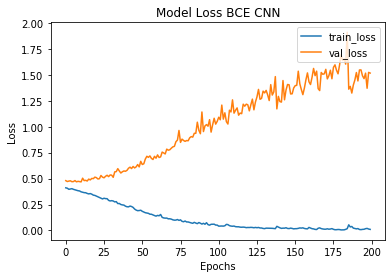

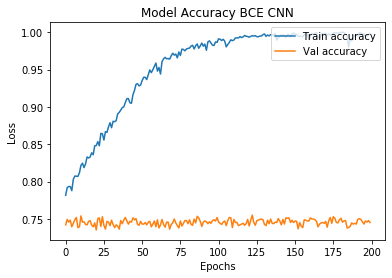

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.806634,0.799519,0.803061,0.745519,0.720821,0.745047
Confirmed,0.633431,0.643815,0.638581,0.745519,0.720821,0.745047


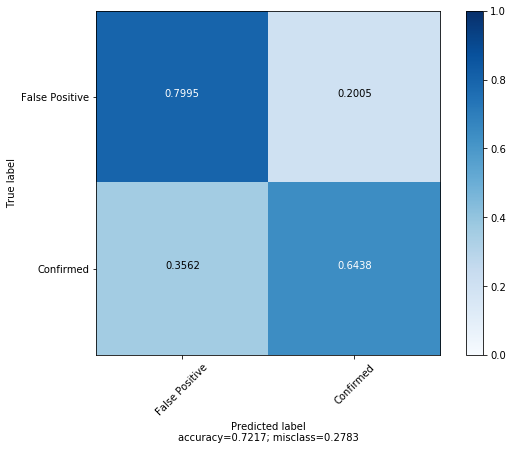

In [97]:
train_model(model, x_train, y_train, x_val, y_val, e=200)

In [102]:
!ls /work/work_teamEXOPLANET/MTF_gabo/npys/

time_channel_30.npy


## Modelo 6

In [79]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 2, 2, 256)         295168    
_________________________________________________________________
global_average_pooling2d_5 ( (None, 256)             

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 4s 851us/step - loss: 0.6199 - acc: 0.6195 - val_loss: 0.5618 - val_acc: 0.6502
Epoch 2/25
4339/4339 [==============================] - 1s 250us/step - loss: 0.5662 - acc: 0.6289 - val_loss: 0.5510 - val_acc: 0.6502
Epoch 3/25
4339/4339 [==============================] - 1s 205us/step - loss: 0.5563 - acc: 0.6204 - val_loss: 0.5528 - val_acc: 0.6502
Epoch 4/25
4339/4339 [==============================] - 1s 200us/step - loss: 0.5449 - acc: 0.6246 - val_loss: 0.5443 - val_acc: 0.6434
Epoch 5/25
4339/4339 [==============================] - 1s 202us/step - loss: 0.5409 - acc: 0.6165 - val_loss: 0.5352 - val_acc: 0.6236
Epoch 6/25
4339/4339 [==============================] - 1s 201us/step - loss: 0.5354 - acc: 0.6197 - val_loss: 0.5413 - val_acc: 0.6220
Epoch 7/25
4339/4339 [==============================] - 1s 201us/step - loss: 0.5359 - acc: 0.6345 - val_loss: 0.5324 - val_acc: 0.6455


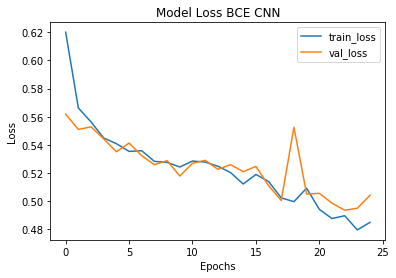

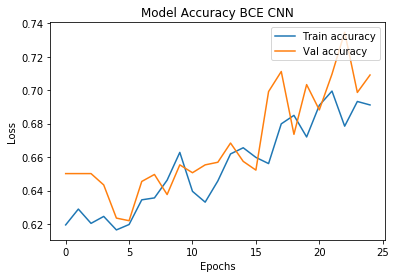

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.713049,0.924619,0.805168,0.672492,0.615547,0.709072
Confirmed,0.687708,0.308495,0.425926,0.672492,0.615547,0.709072


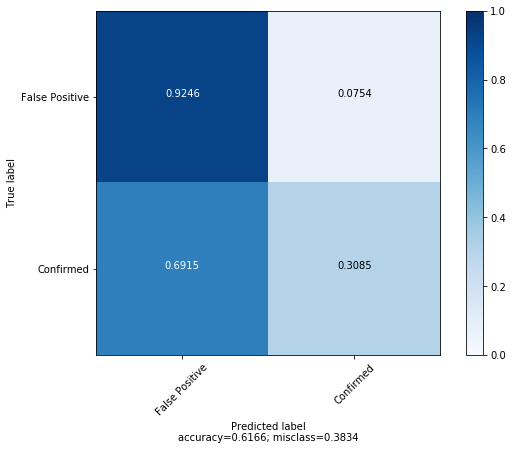

In [80]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 1s 220us/step - loss: 0.4735 - acc: 0.7052 - val_loss: 0.5545 - val_acc: 0.6794
Epoch 2/40
4339/4339 [==============================] - 1s 204us/step - loss: 0.4957 - acc: 0.6771 - val_loss: 0.4856 - val_acc: 0.7409
Epoch 3/40
4339/4339 [==============================] - 1s 202us/step - loss: 0.4685 - acc: 0.7186 - val_loss: 0.5021 - val_acc: 0.7289
Epoch 4/40
4339/4339 [==============================] - 1s 209us/step - loss: 0.4769 - acc: 0.7068 - val_loss: 0.4858 - val_acc: 0.7351
Epoch 5/40
4339/4339 [==============================] - 1s 201us/step - loss: 0.4709 - acc: 0.7091 - val_loss: 0.5140 - val_acc: 0.6976
Epoch 6/40
4339/4339 [==============================] - 1s 203us/step - loss: 0.4749 - acc: 0.6990 - val_loss: 0.5257 - val_acc: 0.6986
Epoch 7/40
4339/4339 [==============================] - 1s 201us/step - loss: 0.4720 - acc: 0.7013 - val_loss: 0.4870 - val_acc: 0.7388


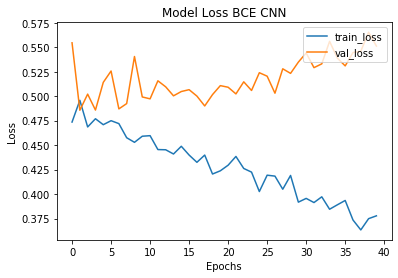

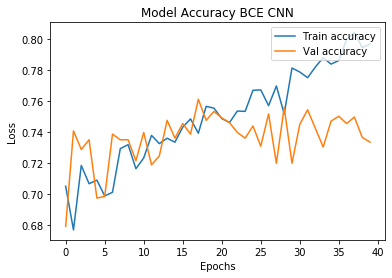

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.826821,0.746592,0.784661,0.737802,0.717689,0.733577
Confirmed,0.601010,0.709389,0.650718,0.737802,0.717689,0.733577


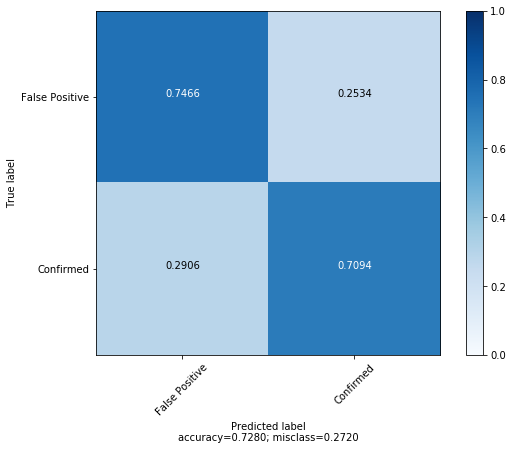

In [81]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 219us/step - loss: 0.3751 - acc: 0.7979 - val_loss: 0.5915 - val_acc: 0.7205
Epoch 2/200
4339/4339 [==============================] - 1s 202us/step - loss: 0.3631 - acc: 0.8083 - val_loss: 0.5752 - val_acc: 0.7424
Epoch 3/200
4339/4339 [==============================] - 1s 202us/step - loss: 0.3446 - acc: 0.8124 - val_loss: 0.5865 - val_acc: 0.7336
Epoch 4/200
4339/4339 [==============================] - 1s 202us/step - loss: 0.3398 - acc: 0.8255 - val_loss: 0.5986 - val_acc: 0.7424
Epoch 5/200
4339/4339 [==============================] - 1s 202us/step - loss: 0.3340 - acc: 0.8295 - val_loss: 0.6401 - val_acc: 0.7409
Epoch 6/200
4339/4339 [==============================] - 1s 202us/step - loss: 0.3441 - acc: 0.8142 - val_loss: 0.5950 - val_acc: 0.7456
Epoch 7/200
4339/4339 [==============================] - 1s 203us/step - loss: 0.3274 - acc: 0.8329 - val_loss: 0.6424 - val_acc: 

4339/4339 [==============================] - 1s 301us/step - loss: 0.0304 - acc: 0.9894 - val_loss: 1.6065 - val_acc: 0.7315
Epoch 61/200
4339/4339 [==============================] - 1s 238us/step - loss: 0.0485 - acc: 0.9823 - val_loss: 1.6663 - val_acc: 0.7216
Epoch 62/200
4339/4339 [==============================] - 2s 398us/step - loss: 0.0638 - acc: 0.9765 - val_loss: 1.6325 - val_acc: 0.7143
Epoch 63/200
4339/4339 [==============================] - 1s 312us/step - loss: 0.1373 - acc: 0.9456 - val_loss: 1.2982 - val_acc: 0.7315
Epoch 64/200
4339/4339 [==============================] - 1s 258us/step - loss: 0.0487 - acc: 0.9829 - val_loss: 1.4384 - val_acc: 0.7398
Epoch 65/200
4339/4339 [==============================] - 1s 261us/step - loss: 0.0216 - acc: 0.9961 - val_loss: 1.5629 - val_acc: 0.7310
Epoch 66/200
4339/4339 [==============================] - 1s 291us/step - loss: 0.0265 - acc: 0.9912 - val_loss: 1.6093 - val_acc: 0.7377
Epoch 67/200
4339/4339 [=======================

4339/4339 [==============================] - 1s 264us/step - loss: 0.0038 - acc: 0.9998 - val_loss: 2.5068 - val_acc: 0.7424
Epoch 120/200
4339/4339 [==============================] - 1s 280us/step - loss: 0.0038 - acc: 0.9998 - val_loss: 2.5113 - val_acc: 0.7430
Epoch 121/200
4339/4339 [==============================] - 1s 249us/step - loss: 0.0038 - acc: 0.9998 - val_loss: 2.5121 - val_acc: 0.7398
Epoch 122/200
4339/4339 [==============================] - 1s 287us/step - loss: 0.0038 - acc: 0.9998 - val_loss: 2.5190 - val_acc: 0.7414
Epoch 123/200
4339/4339 [==============================] - 1s 244us/step - loss: 0.0038 - acc: 0.9998 - val_loss: 2.5287 - val_acc: 0.7440
Epoch 124/200
4339/4339 [==============================] - 1s 254us/step - loss: 0.0038 - acc: 0.9998 - val_loss: 2.5356 - val_acc: 0.7440
Epoch 125/200
4339/4339 [==============================] - 1s 312us/step - loss: 0.0038 - acc: 0.9998 - val_loss: 2.5338 - val_acc: 0.7435
Epoch 126/200
4339/4339 [================

4339/4339 [==============================] - 1s 201us/step - loss: 0.0037 - acc: 0.9998 - val_loss: 2.7616 - val_acc: 0.7424
Epoch 179/200
4339/4339 [==============================] - 1s 239us/step - loss: 0.0037 - acc: 0.9998 - val_loss: 2.7724 - val_acc: 0.7435
Epoch 180/200
4339/4339 [==============================] - 1s 268us/step - loss: 0.0037 - acc: 0.9998 - val_loss: 2.7677 - val_acc: 0.7424
Epoch 181/200
4339/4339 [==============================] - 1s 273us/step - loss: 0.0037 - acc: 0.9998 - val_loss: 2.7808 - val_acc: 0.7440
Epoch 182/200
4339/4339 [==============================] - 1s 273us/step - loss: 0.0037 - acc: 0.9998 - val_loss: 2.7831 - val_acc: 0.7430
Epoch 183/200
4339/4339 [==============================] - 1s 275us/step - loss: 0.0037 - acc: 0.9998 - val_loss: 2.7834 - val_acc: 0.7409
Epoch 184/200
4339/4339 [==============================] - 1s 206us/step - loss: 0.0037 - acc: 0.9998 - val_loss: 2.7857 - val_acc: 0.7414
Epoch 185/200
4339/4339 [================

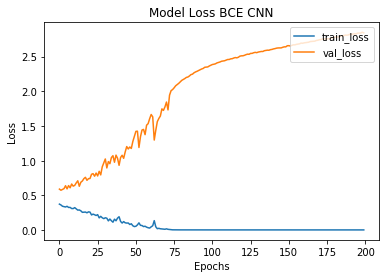

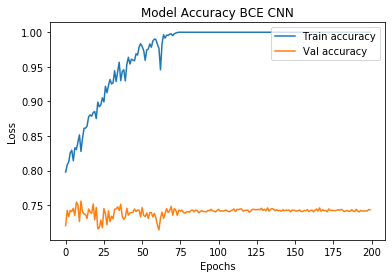

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.807661,0.794707,0.801132,0.744329,0.719949,0.743483
Confirmed,0.629522,0.648286,0.638767,0.744329,0.719949,0.743483


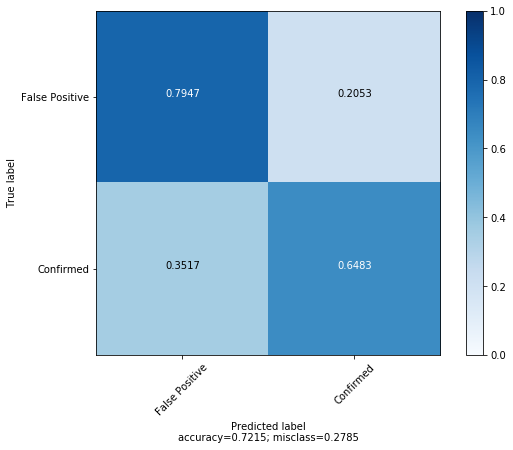

In [82]:
train_model(model, x_train, y_train, x_val, y_val, e=200)

## Pruebas CNN utilizando loss = Focal_Loss

In [32]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.79497985 1.34751553]


In [33]:
import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [34]:
## experimetanciones varias -- modelo 1
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

#model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.6, gamma=2),optimizer='Adam',metrics=['accuracy'])
#model.compile(loss=binary_focal_loss(alpha=.25, gamma=2),optimizer='Adam',metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 277us/step - loss: 7.6437 - acc: 0.6617 - val_loss: 7.7073 - val_acc: 0.6668
Epoch 2/200
4339/4339 [==============================] - 1s 250us/step - loss: 7.5395 - acc: 0.6651 - val_loss: 8.2298 - val_acc: 0.6184
Epoch 3/200
4339/4339 [==============================] - 1s 250us/step - loss: 7.7461 - acc: 0.6619 - val_loss: 7.7407 - val_acc: 0.6418
Epoch 4/200
4339/4339 [==============================] - 1s 251us/step - loss: 7.6651 - acc: 0.6663 - val_loss: 7.6635 - val_acc: 0.6616
Epoch 5/200
4339/4339 [==============================] - 1s 250us/step - loss: 7.4893 - acc: 0.6776 - val_loss: 7.7595 - val_acc: 0.7049
Epoch 6/200
4339/4339 [==============================] - 1s 251us/step - loss: 7.4836 - acc: 0.6843 - val_loss: 7.8018 - val_acc: 0.6543
Epoch 7/200
4339/4339 [==============================] - 1s 250us/step - loss: 7.4244 - acc: 0.6815 - val_loss: 7.4717 - val_acc: 

4339/4339 [==============================] - 1s 250us/step - loss: 4.5363 - acc: 0.8592 - val_loss: 10.2925 - val_acc: 0.7633
Epoch 61/200
4339/4339 [==============================] - 1s 252us/step - loss: 4.1728 - acc: 0.8753 - val_loss: 11.1485 - val_acc: 0.7680
Epoch 62/200
4339/4339 [==============================] - 1s 249us/step - loss: 4.4012 - acc: 0.8719 - val_loss: 9.7509 - val_acc: 0.7706
Epoch 63/200
4339/4339 [==============================] - 1s 250us/step - loss: 4.0644 - acc: 0.8848 - val_loss: 11.4437 - val_acc: 0.7706
Epoch 64/200
4339/4339 [==============================] - 1s 251us/step - loss: 3.9115 - acc: 0.8896 - val_loss: 11.1276 - val_acc: 0.7544
Epoch 65/200
4339/4339 [==============================] - 1s 249us/step - loss: 3.7774 - acc: 0.8981 - val_loss: 12.9132 - val_acc: 0.7685
Epoch 66/200
4339/4339 [==============================] - 1s 247us/step - loss: 4.0122 - acc: 0.8866 - val_loss: 13.5301 - val_acc: 0.7294
Epoch 67/200
4339/4339 [=================

Epoch 119/200
4339/4339 [==============================] - 1s 246us/step - loss: 0.0541 - acc: 1.0000 - val_loss: 32.3885 - val_acc: 0.7675
Epoch 120/200
4339/4339 [==============================] - 1s 246us/step - loss: 0.0579 - acc: 1.0000 - val_loss: 33.5804 - val_acc: 0.7617
Epoch 121/200
4339/4339 [==============================] - 1s 247us/step - loss: 0.0517 - acc: 1.0000 - val_loss: 32.4637 - val_acc: 0.7685
Epoch 122/200
4339/4339 [==============================] - 1s 247us/step - loss: 0.0448 - acc: 1.0000 - val_loss: 32.9726 - val_acc: 0.7706
Epoch 123/200
4339/4339 [==============================] - 1s 246us/step - loss: 0.0411 - acc: 1.0000 - val_loss: 32.7346 - val_acc: 0.7690
Epoch 124/200
4339/4339 [==============================] - 1s 245us/step - loss: 0.0394 - acc: 1.0000 - val_loss: 34.8703 - val_acc: 0.7623
Epoch 125/200
4339/4339 [==============================] - 1s 247us/step - loss: 0.0577 - acc: 1.0000 - val_loss: 32.7571 - val_acc: 0.7649
Epoch 126/200
4339/4

4339/4339 [==============================] - 1s 245us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 39.0131 - val_acc: 0.7612
Epoch 178/200
4339/4339 [==============================] - 1s 246us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 39.1995 - val_acc: 0.7638
Epoch 179/200
4339/4339 [==============================] - 1s 246us/step - loss: 0.0112 - acc: 1.0000 - val_loss: 38.9728 - val_acc: 0.7628
Epoch 180/200
4339/4339 [==============================] - 1s 246us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 39.5149 - val_acc: 0.7675
Epoch 181/200
4339/4339 [==============================] - 1s 246us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 39.4615 - val_acc: 0.7669
Epoch 182/200
4339/4339 [==============================] - 1s 245us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 39.3813 - val_acc: 0.7654
Epoch 183/200
4339/4339 [==============================] - 1s 245us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 39.4486 - val_acc: 0.7664
Epoch 184/200
4339/4339 [=========

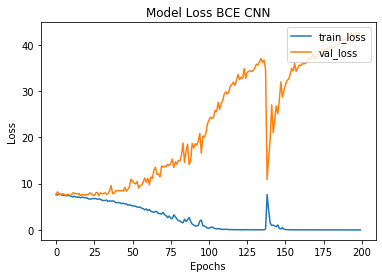

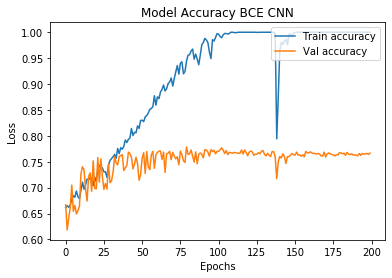

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.823482,0.815557,0.819500,0.766894,0.744314,0.766423
Confirmed,0.663250,0.675112,0.669129,0.766894,0.744314,0.766423


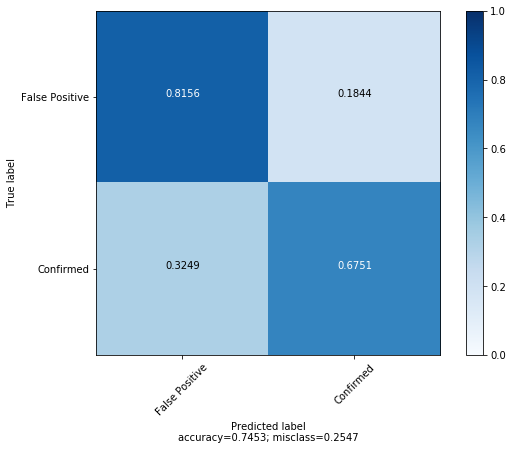

In [36]:
train_model(model, x_train, y_train, x_val, y_val, e=200) #old test

Train on 4339 samples, validate on 1918 samples
Epoch 1/500
4339/4339 [==============================] - 1s 273us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 42.2360 - val_acc: 0.7664
Epoch 2/500
4339/4339 [==============================] - 1s 244us/step - loss: 7.4984 - acc: 0.9193 - val_loss: 10.3243 - val_acc: 0.5975
Epoch 3/500
4339/4339 [==============================] - 1s 244us/step - loss: 8.4845 - acc: 0.6386 - val_loss: 8.7201 - val_acc: 0.6017
Epoch 4/500
4339/4339 [==============================] - 1s 246us/step - loss: 8.1897 - acc: 0.6370 - val_loss: 9.4010 - val_acc: 0.6382
Epoch 5/500
4339/4339 [==============================] - 1s 244us/step - loss: 7.9092 - acc: 0.6536 - val_loss: 9.0803 - val_acc: 0.6601
Epoch 6/500
4339/4339 [==============================] - 1s 246us/step - loss: 7.4725 - acc: 0.6956 - val_loss: 9.2828 - val_acc: 0.7091
Epoch 7/500
4339/4339 [==============================] - 1s 244us/step - loss: 7.3399 - acc: 0.7043 - val_loss: 10.2236 - val_ac

Epoch 60/500
4339/4339 [==============================] - 1s 246us/step - loss: 0.0608 - acc: 1.0000 - val_loss: 32.6229 - val_acc: 0.7628
Epoch 61/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0541 - acc: 1.0000 - val_loss: 33.6644 - val_acc: 0.7643
Epoch 62/500
4339/4339 [==============================] - 1s 246us/step - loss: 0.0464 - acc: 1.0000 - val_loss: 34.2443 - val_acc: 0.7586
Epoch 63/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0393 - acc: 1.0000 - val_loss: 33.9718 - val_acc: 0.7617
Epoch 64/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0341 - acc: 1.0000 - val_loss: 34.3169 - val_acc: 0.7602
Epoch 65/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0352 - acc: 1.0000 - val_loss: 34.5396 - val_acc: 0.7617
Epoch 66/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0345 - acc: 1.0000 - val_loss: 34.6485 - val_acc: 0.7602
Epoch 67/500
4339/4339 [===

Epoch 119/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0137 - acc: 1.0000 - val_loss: 38.5304 - val_acc: 0.7617
Epoch 120/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0141 - acc: 1.0000 - val_loss: 39.1819 - val_acc: 0.7633
Epoch 121/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0136 - acc: 1.0000 - val_loss: 38.9317 - val_acc: 0.7623
Epoch 122/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0111 - acc: 1.0000 - val_loss: 39.4423 - val_acc: 0.7617
Epoch 123/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 39.5307 - val_acc: 0.7607
Epoch 124/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 39.6290 - val_acc: 0.7596
Epoch 125/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0100 - acc: 1.0000 - val_loss: 39.8205 - val_acc: 0.7617
Epoch 126/500
4339/4

4339/4339 [==============================] - 1s 245us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 46.4449 - val_acc: 0.7654
Epoch 178/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 47.2516 - val_acc: 0.7623
Epoch 179/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 46.5760 - val_acc: 0.7649
Epoch 180/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 47.2357 - val_acc: 0.7664
Epoch 181/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 46.7386 - val_acc: 0.7628
Epoch 182/500
4339/4339 [==============================] - 1s 246us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 47.2390 - val_acc: 0.7649
Epoch 183/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 47.0473 - val_acc: 0.7638
Epoch 184/500
4339/4339 [=========

4339/4339 [==============================] - 1s 249us/step - loss: 0.0134 - acc: 1.0000 - val_loss: 42.2880 - val_acc: 0.7471
Epoch 236/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 42.6453 - val_acc: 0.7534
Epoch 237/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0156 - acc: 1.0000 - val_loss: 42.4695 - val_acc: 0.7529
Epoch 238/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0175 - acc: 1.0000 - val_loss: 42.7004 - val_acc: 0.7518
Epoch 239/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 43.1061 - val_acc: 0.7513
Epoch 240/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0129 - acc: 1.0000 - val_loss: 43.4997 - val_acc: 0.7508
Epoch 241/500
4339/4339 [==============================] - 1s 246us/step - loss: 0.0110 - acc: 1.0000 - val_loss: 43.9136 - val_acc: 0.7492
Epoch 242/500
4339/4339 [=========

4339/4339 [==============================] - 1s 245us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 51.2342 - val_acc: 0.7534
Epoch 294/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 51.5942 - val_acc: 0.7503
Epoch 295/500
4339/4339 [==============================] - 1s 248us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 52.2327 - val_acc: 0.7503
Epoch 296/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 51.6805 - val_acc: 0.7534
Epoch 297/500
4339/4339 [==============================] - 1s 246us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 52.7085 - val_acc: 0.7539
Epoch 298/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 53.1996 - val_acc: 0.7523
Epoch 299/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 53.2918 - val_acc: 0.7497
Epoch 300/500
4339/4339 [=========

4339/4339 [==============================] - 1s 244us/step - loss: 0.0335 - acc: 1.0000 - val_loss: 40.8632 - val_acc: 0.7466
Epoch 352/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0286 - acc: 1.0000 - val_loss: 41.7452 - val_acc: 0.7461
Epoch 353/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0214 - acc: 1.0000 - val_loss: 41.9296 - val_acc: 0.7487
Epoch 354/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0271 - acc: 1.0000 - val_loss: 42.0172 - val_acc: 0.7523
Epoch 355/500
4339/4339 [==============================] - 1s 244us/step - loss: 0.0214 - acc: 1.0000 - val_loss: 42.4442 - val_acc: 0.7513
Epoch 356/500
4339/4339 [==============================] - 1s 246us/step - loss: 0.0198 - acc: 1.0000 - val_loss: 43.1005 - val_acc: 0.7440
Epoch 357/500
4339/4339 [==============================] - 1s 246us/step - loss: 0.0172 - acc: 1.0000 - val_loss: 43.4769 - val_acc: 0.7487
Epoch 358/500
4339/4339 [=========

4339/4339 [==============================] - 1s 248us/step - loss: 0.0860 - acc: 0.9995 - val_loss: 41.2927 - val_acc: 0.7482
Epoch 410/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0341 - acc: 0.9995 - val_loss: 43.9621 - val_acc: 0.7539
Epoch 411/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0137 - acc: 1.0000 - val_loss: 44.5342 - val_acc: 0.7461
Epoch 412/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 45.1568 - val_acc: 0.7497
Epoch 413/500
4339/4339 [==============================] - 1s 246us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 45.7835 - val_acc: 0.7471
Epoch 414/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 46.7766 - val_acc: 0.7497
Epoch 415/500
4339/4339 [==============================] - 1s 248us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 47.2247 - val_acc: 0.7477
Epoch 416/500
4339/4339 [=========

4339/4339 [==============================] - 1s 248us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 58.6048 - val_acc: 0.7477
Epoch 468/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 58.5759 - val_acc: 0.7482
Epoch 469/500
4339/4339 [==============================] - 1s 256us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 58.1176 - val_acc: 0.7435
Epoch 470/500
4339/4339 [==============================] - 1s 246us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 57.3805 - val_acc: 0.7503
Epoch 471/500
4339/4339 [==============================] - 1s 248us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 57.9197 - val_acc: 0.7513
Epoch 472/500
4339/4339 [==============================] - 1s 247us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 58.5636 - val_acc: 0.7503
Epoch 473/500
4339/4339 [==============================] - 1s 245us/step - loss: 0.0010 - acc: 1.0000 - val_loss: 59.1962 - val_acc: 0.7518
Epoch 474/500
4339/4339 [=========

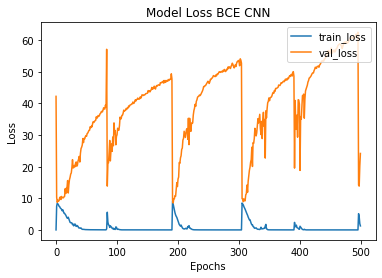

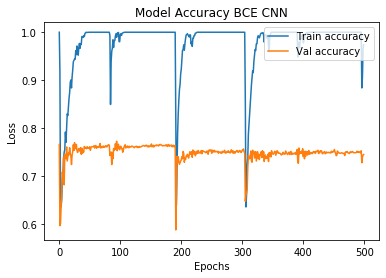

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.837934,0.754611,0.794093,0.749673,0.730607,0.745568
Confirmed,0.615094,0.728763,0.667121,0.749673,0.730607,0.745568


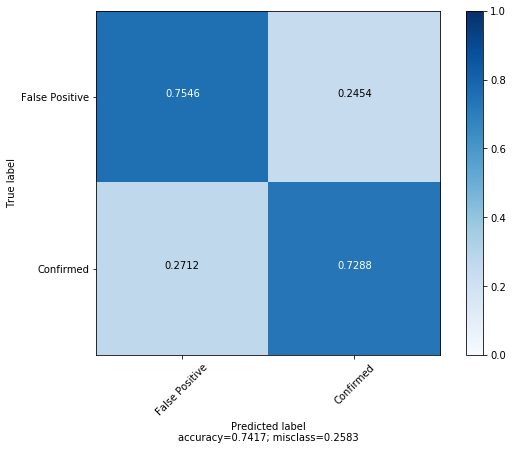

In [37]:
train_model(model, x_train, y_train, x_val, y_val, e=500)

In [38]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.6, gamma=2),optimizer='Adam',metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               147584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)              

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 491us/step - loss: 9.5341 - acc: 0.6160 - val_loss: 8.8655 - val_acc: 0.6210
Epoch 2/40
4339/4339 [==============================] - 1s 122us/step - loss: 8.9158 - acc: 0.6241 - val_loss: 8.6068 - val_acc: 0.6335
Epoch 3/40
4339/4339 [==============================] - 0s 111us/step - loss: 8.6651 - acc: 0.6225 - val_loss: 8.4527 - val_acc: 0.6283
Epoch 4/40
4339/4339 [==============================] - 0s 108us/step - loss: 8.5557 - acc: 0.6324 - val_loss: 8.3484 - val_acc: 0.6418
Epoch 5/40
4339/4339 [==============================] - 0s 109us/step - loss: 8.4188 - acc: 0.6356 - val_loss: 8.2722 - val_acc: 0.6283
Epoch 6/40
4339/4339 [==============================] - 1s 119us/step - loss: 8.3193 - acc: 0.6368 - val_loss: 8.2366 - val_acc: 0.6303
Epoch 7/40
4339/4339 [==============================] - 0s 114us/step - loss: 8.2364 - acc: 0.6425 - val_loss: 8.1229 - val_acc: 0.6496


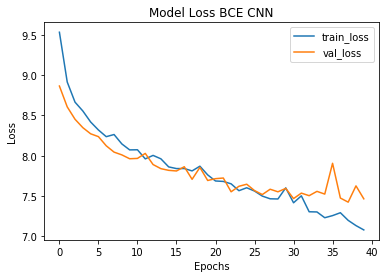

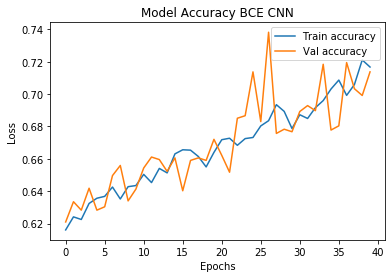

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.884361,0.643945,0.745244,0.720113,0.709326,0.713764
Confirmed,0.560396,0.843517,0.673409,0.720113,0.709326,0.713764


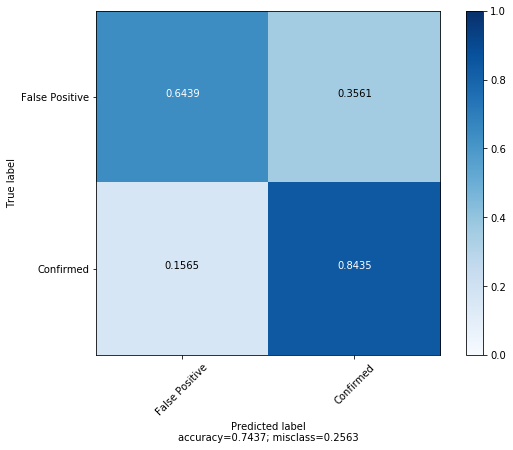

In [39]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 121us/step - loss: 7.0741 - acc: 0.7145 - val_loss: 7.4951 - val_acc: 0.7273
Epoch 2/200
4339/4339 [==============================] - 0s 113us/step - loss: 7.0551 - acc: 0.7221 - val_loss: 7.4081 - val_acc: 0.7028
Epoch 3/200
4339/4339 [==============================] - 0s 110us/step - loss: 6.9932 - acc: 0.7260 - val_loss: 7.7262 - val_acc: 0.6945
Epoch 4/200
4339/4339 [==============================] - 0s 109us/step - loss: 6.9359 - acc: 0.7260 - val_loss: 7.4554 - val_acc: 0.7346
Epoch 5/200
4339/4339 [==============================] - 0s 115us/step - loss: 6.8868 - acc: 0.7269 - val_loss: 7.5993 - val_acc: 0.6950
Epoch 6/200
4339/4339 [==============================] - 0s 108us/step - loss: 6.8614 - acc: 0.7290 - val_loss: 7.6264 - val_acc: 0.7132
Epoch 7/200
4339/4339 [==============================] - 0s 108us/step - loss: 6.7480 - acc: 0.7430 - val_loss: 7.5982 - val_acc: 

Epoch 60/200
4339/4339 [==============================] - 0s 111us/step - loss: 3.0892 - acc: 0.9203 - val_loss: 12.8426 - val_acc: 0.7351
Epoch 61/200
4339/4339 [==============================] - 0s 110us/step - loss: 2.9026 - acc: 0.9258 - val_loss: 14.0232 - val_acc: 0.7607
Epoch 62/200
4339/4339 [==============================] - 0s 108us/step - loss: 2.7543 - acc: 0.9329 - val_loss: 13.3223 - val_acc: 0.7404
Epoch 63/200
4339/4339 [==============================] - 0s 109us/step - loss: 2.7211 - acc: 0.9292 - val_loss: 17.8125 - val_acc: 0.7450
Epoch 64/200
4339/4339 [==============================] - 0s 108us/step - loss: 2.7485 - acc: 0.9309 - val_loss: 14.0284 - val_acc: 0.7445
Epoch 65/200
4339/4339 [==============================] - 0s 109us/step - loss: 2.6826 - acc: 0.9292 - val_loss: 15.3946 - val_acc: 0.7508
Epoch 66/200
4339/4339 [==============================] - 0s 109us/step - loss: 2.5829 - acc: 0.9378 - val_loss: 15.9521 - val_acc: 0.7383
Epoch 67/200
4339/4339 [===

Epoch 119/200
4339/4339 [==============================] - 0s 110us/step - loss: 0.6542 - acc: 0.9878 - val_loss: 29.8059 - val_acc: 0.7424
Epoch 120/200
4339/4339 [==============================] - 0s 108us/step - loss: 1.6309 - acc: 0.9587 - val_loss: 28.9489 - val_acc: 0.7445
Epoch 121/200
4339/4339 [==============================] - 0s 107us/step - loss: 1.0310 - acc: 0.9746 - val_loss: 28.3926 - val_acc: 0.7310
Epoch 122/200
4339/4339 [==============================] - 0s 108us/step - loss: 0.7936 - acc: 0.9832 - val_loss: 31.1247 - val_acc: 0.7576
Epoch 123/200
4339/4339 [==============================] - 0s 107us/step - loss: 0.6247 - acc: 0.9871 - val_loss: 31.4520 - val_acc: 0.7534
Epoch 124/200
4339/4339 [==============================] - 0s 107us/step - loss: 0.3602 - acc: 0.9956 - val_loss: 31.9760 - val_acc: 0.7362
Epoch 125/200
4339/4339 [==============================] - 0s 107us/step - loss: 0.4479 - acc: 0.9912 - val_loss: 33.6199 - val_acc: 0.7518
Epoch 126/200
4339/4

4339/4339 [==============================] - 0s 108us/step - loss: 0.6463 - acc: 0.9864 - val_loss: 41.4074 - val_acc: 0.7310
Epoch 178/200
4339/4339 [==============================] - 0s 108us/step - loss: 0.9642 - acc: 0.9783 - val_loss: 32.6420 - val_acc: 0.7304
Epoch 179/200
4339/4339 [==============================] - 0s 107us/step - loss: 1.2574 - acc: 0.9680 - val_loss: 36.9654 - val_acc: 0.7127
Epoch 180/200
4339/4339 [==============================] - 0s 109us/step - loss: 0.8554 - acc: 0.9818 - val_loss: 38.6619 - val_acc: 0.7424
Epoch 181/200
4339/4339 [==============================] - 0s 109us/step - loss: 0.5604 - acc: 0.9882 - val_loss: 37.8973 - val_acc: 0.7320
Epoch 182/200
4339/4339 [==============================] - 0s 108us/step - loss: 0.4374 - acc: 0.9912 - val_loss: 39.6554 - val_acc: 0.7325
Epoch 183/200
4339/4339 [==============================] - 0s 108us/step - loss: 0.9068 - acc: 0.9811 - val_loss: 31.0822 - val_acc: 0.7310
Epoch 184/200
4339/4339 [=========

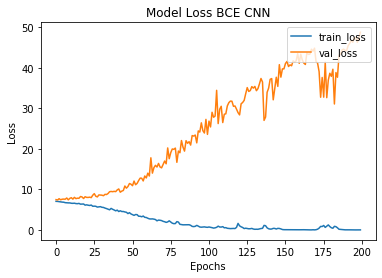

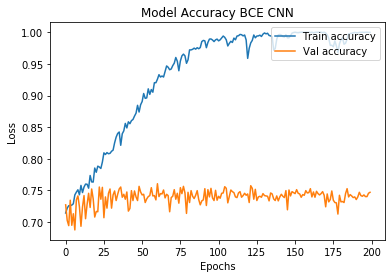

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.800000,0.814755,0.807310,0.746083,0.719804,0.747132
Confirmed,0.643519,0.621461,0.632297,0.746083,0.719804,0.747132


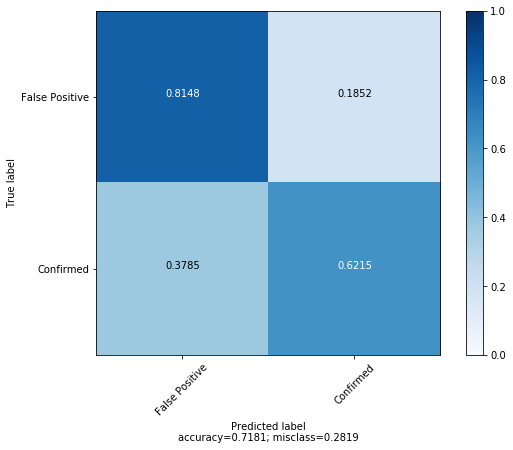

In [40]:
train_model(model, x_train, y_train, x_val, y_val, e=200)